In [1]:
from __future__ import print_function
import os

import pandas as pd
from PIL import Image
import numpy as np

import chainer
from chainer.dataset import convert
import chainer.links as L
import chainer.functions as F
import chainer.initializers as I
from chainer import serializers

import utils

Using TensorFlow backend.
/home/fytroo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### ハイパーパラメータ

In [2]:
from easydict import EasyDict
args = EasyDict({
    'bs': 16, 
    'epoch' : 100,
    'lr' : 0.001,
    'gpu': 0,
    'out': 'result',
    'resume': '',
})
try:
    __file__.endswith('py')
    import argparse
    parser = argparse.ArgumentParser(description='Chainer example: MNIST')
    parser.add_argument('--batchsize', '-b', dest='bs', type=int, default=args.bs,
                        help='Number of images in each mini-batch')
    parser.add_argument('--epoch', '-e', type=int, default=args.epoch,
                        help='Number of sweeps over the dataset to train')
    parser.add_argument('--learningrate', '-l', dest='lr', type=float, default=args.lr,
                        help='Number of sweeps over the dataset to train')
    parser.add_argument('--frequency', '-f', type=int, default=-1,
                        help='Frequency of taking a snapshot')
    parser.add_argument('--gpu', '-g', type=int, default=args.gpu,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default=args.out,
                        help='Directory to output the result')
    parser.add_argument('--resume', '-r', default=args.resume,
                        help='Resume the training from snapshot')
    parser.add_argument('--unit', '-u', dest='n_in', type=int, default=args.n_in,
                        help='Number of units')
    parser.add_argument('--noplot', dest='plot', action='store_false',
                        help='Disable PlotReport extension')
    args = parser.parse_args()
except:
    print('no argsparse')
    pass

no argsparse


### データセット読み込み

In [3]:
from tuner import load_data

In [4]:
import os

In [5]:
dataset_dir = 'datasets/birds-datasets'
resize = 128

In [6]:
df = load_data.df_fromdir(dataset_dir)
df_train, df_val = load_data.train_val_split_df(df)
x_train, y_train = load_data.load_fromdf(df_train, resize=resize, rescale=1) 
x_val, y_val = load_data.load_fromdf(df_val, resize=resize, rescale=1) 

/home/fytroo/anaconda3/lib/python3.6/site-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [7]:
x_val.shape, y_val.shape

((30, 128, 128, 3), (30,))

In [8]:
if len(y_val) < args.bs:
    raise 'oops!'

### モデルを定義

In [9]:
class LeNet(chainer.Chain):
    def __init__(self, n_out=10):
        super(LeNet, self).__init__()
        
        initialW= I.HeNormal()
        with self.init_scope():
            self.conv0 = L.Convolution2D(None, 16, 1, 1, 0, initialW=initialW, nobias=True)
            
            self.bn11 = L.BatchNormalization(16)
            self.conv11 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn12 = L.BatchNormalization(32)
            self.conv12 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.bn21 = L.BatchNormalization(32)
            self.conv21 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn22 = L.BatchNormalization(64)
            self.conv22 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.conv_out = L.Convolution2D(None, n_out)
            self.fc = L.Linear(None, n_out)
    
    def __call__(self, x):
        h = x
        h = self.conv0(h)
        
        h = self.bn11(h)
        h = F.relu(h)
        h = self.conv11(h)
        h = self.bn12(h)
        h = F.relu(h)
        h = self.conv12(h)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        
        h = self.bn21(h)
        h = F.relu(h)
        h = self.conv21(h)
        h = self.bn22(h)
        h = F.relu(h)
        h = self.conv22(h)
        
        print('#1', h.shape)
        h = self.conv_out(h)
        print('#2', h.shape)
        h = F.squeeze(F.average_ppoling_2d(h,4))
        print('#3', h.shape)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        print('#4', h.shape)
        h = self.fc(h)
        
        return h

In [10]:
class LeNet(chainer.Chain):
    def __init__(self, n_out=10):
        super(LeNet, self).__init__()
        
        initialW= I.HeNormal()
        with self.init_scope():
            self.conv0 = L.Convolution2D(None, 16, 1, 1, 0, initialW=initialW, nobias=True)
            
            self.bn11 = L.BatchNormalization(16)
            self.conv11 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn12 = L.BatchNormalization(32)
            self.conv12 = L.Convolution2D(None, 32, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.bn21 = L.BatchNormalization(32)
            self.conv21 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            self.bn22 = L.BatchNormalization(64)
            self.conv22 = L.Convolution2D(None, 64, 3, 1, 1, initialW=initialW, nobias=True)
            
            self.conv_out = L.Convolution2D(None, n_out)
            self.fc = L.Linear(None, n_out)
    
    def __call__(self, x):
        h = x
        h = self.conv0(h)
        
        h = self.bn11(h)
        h = F.relu(h)
        h = self.conv11(h)
        h = self.bn12(h)
        h = F.relu(h)
        h = self.conv12(h)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(h, ratio=0.4)
        
        h = self.bn21(h)
        h = F.relu(h)
        h = self.conv21(h)
        h = self.bn22(h)
        h = F.relu(h)
        h = self.conv22(h)
        h = F.average_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(h, ratio=0.4)
        
        h = self.fc(h)
        
        return h

In [11]:
n_label = np.unique(y_train).size
model = L.Classifier(LeNet(n_label),
                    lossfun=F.softmax_cross_entropy,
                    accfun=F.accuracy)
xp = np
if args.gpu >= 0:
    import cupy as cp
    xp = cp
    chainer.cuda.get_device_from_id(args.gpu).use()
    model.to_gpu()  # Copy the model to the GPU
optimizer = chainer.optimizers.Adam(args.lr)
optimizer.setup(model)

In [12]:
from PIL import Image
x = ( load_data.arr2img(x) for x in x_train)

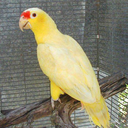

In [13]:
next(x)

### data augmentation

In [14]:
import Augmentor
p = Augmentor.Pipeline()
#p.crop_random(probability=1, percentage_area=0.8)
#p.resize(probability=1, width=resize, height=resize)
#p.flip_left_right(probability=0.5)
#p.random_erasing(probability=0.5, rectangle_area=0.5)
#p.shear(probability=0.3, max_shear_left=2, max_shear_right=2)
#
g = p.keras_generator_from_array(x_train, y_train, batch_size=args.bs)

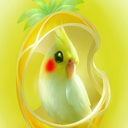

In [15]:
xs, ys = next(g)
load_data.arr2img(xs[1])

In [16]:
g = ((
    xp.array(np.swapaxes((x/255.), 1, 3)).astype(np.float32),
    xp.array(y.astype(np.int8))
    ) for (x,y) in g)

### 訓練と検証

In [17]:
def train(step=None):
    xs, ts = next(g) 
    x = chainer.Variable(xs)
    t = chainer.Variable(ts)
    optimizer.update(model, x, t)
    with chainer.using_config('train', True):
        loss = model(x,t)

    loss = float(loss.data)
    acc = float(model.accuracy.data)

    if step%100==0:
        print('step:{}'.format(step))
        print('loss: {:.4f}\t acc: {:.4f}'.format(loss, acc))
    
def validation(step=None):
    xs = xp.array(np.swapaxes((x_val), 1, 3)).astype(np.float32)
    ts = xp.array(y_val).astype(np.int8)
    x = chainer.Variable(xs)
    t = chainer.Variable(ts)
    with chainer.using_config('train', True):
        loss = model(x,t)

    loss = float(loss.data)
    acc = float(model.accuracy.data)
    
    print('val_loss: {:.4f}\t val_acc: {:.4f}'.format(loss, acc))

In [ ]:
if __name__ == '__main__':
    #for step in range(args.epoch):
    for step in range(10**5):
        train(step)
        if step%2000==0:
            validation(step)

step:0
loss: 2.5109	 acc: 0.6250
val_loss: 9.4848	 val_acc: 0.2667
step:100
loss: 0.7799	 acc: 0.7500
step:200
loss: 1.4645	 acc: 0.4375
step:300
loss: 1.1670	 acc: 0.5000
step:400
loss: 0.7642	 acc: 0.8125
step:500
loss: 0.4218	 acc: 0.8125
step:600
loss: 0.7333	 acc: 0.7500
step:700
loss: 0.6420	 acc: 0.8750
step:800
loss: 0.5815	 acc: 0.7500
step:900
loss: 0.3048	 acc: 0.8125
step:1000
loss: 0.8428	 acc: 0.7500
step:1100
loss: 0.3939	 acc: 0.8125
step:1200
loss: 0.4331	 acc: 0.8125
step:1300
loss: 0.3374	 acc: 0.8750
step:1400
loss: 0.8814	 acc: 0.7500
step:1500
loss: 0.5372	 acc: 0.7500
step:1600
loss: 0.4241	 acc: 0.9375
step:1700
loss: 0.2854	 acc: 0.8750
step:1800
loss: 0.2099	 acc: 0.8750
step:1900
loss: 0.4200	 acc: 0.7500
step:2000
loss: 0.2006	 acc: 0.9375
val_loss: 0.6679	 val_acc: 0.7667
step:2100
loss: 0.2522	 acc: 0.9375
step:2200
loss: 0.1932	 acc: 0.9375
step:2300
loss: 0.2278	 acc: 0.9375
step:2400
loss: 0.2275	 acc: 0.8750
step:2500
loss: 0.7115	 acc: 0.6875
step:260

In [ ]:
model.predict(x_test)